## Import packages

In [1]:
import numpy as np
import pandas as pd
import pygimli as pg
from pygimli.physics import ert
import matplotlib.pyplot as plt
import math
import sys
from ipywidgets import interact
import matplotlib.patches as patches
import matplotlib.dates as mdates
import matplotlib.colors as colors  
import ipywidgets as widgets
import datetime
import matplotlib as mpl


## plotting preferences

In [2]:
dpi = 300 # image resoltuion in saved figs
fs = 12 # font size in saved figs

## Load the data

In [3]:
# load data (separated into electrodes and data file for convenience)

elecs = pd.read_csv('data_AERT/craterlake_electrodes.txt', sep='\t')
data_in = pd.read_csv('data_AERT/craterlake_data.txt',sep='\t')

# specify number of data points per dataset (57) and lines in header (3)

n_data = 57
n_header = 3
n_lines = n_data + n_header
n_surveys = int(len(data_in)/(n_lines))

# get electrodes

A = (elecs['A'].to_numpy())
B = (elecs['B'].to_numpy())
M = (elecs['M'].to_numpy())
N = (elecs['N'].to_numpy())

E = np.linspace(0,9.5,20) # positions


## Make a grid

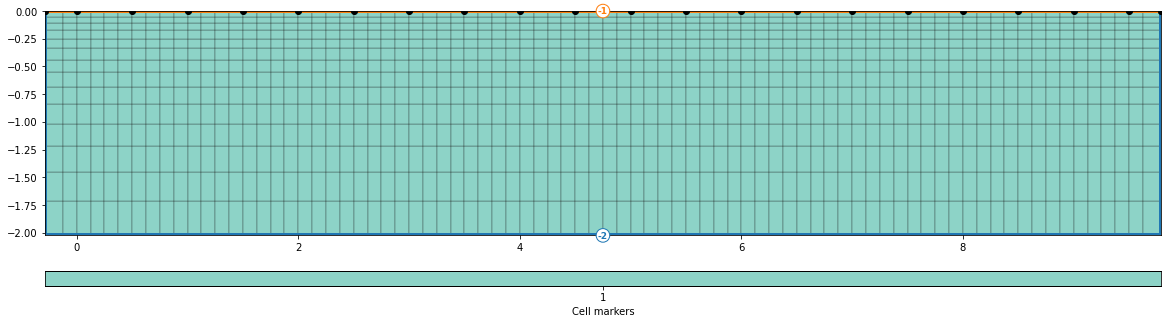

In [4]:
n_elec = len(E)
e_spc = E[1]-E[0] # assumes constant spacing for now
nb = 4 # set number of cells between electrodes

# discretization in x-direction

hx = (np.ones((n_elec-1)*nb)*(e_spc/nb))
nxpad = 2
padx = (e_spc/nb)*1.3**(np.arange(0,nxpad,1))
xlocs = np.cumsum(np.hstack([0,np.flipud(padx), hx, padx]))-sum(padx)

# discretization in z-direction

pady = 0.05*1.15**(np.arange(0,14,1))
ylocs = np.flipud(-np.cumsum(np.hstack([0,pady])))

# make grid

grid = pg.createGrid(
    x=xlocs,
    y=ylocs,
    marker=1, 
    worldBoundaryMarker=True
)

# plot grid

fig, ax = plt.subplots(figsize=[20,10])
pg.show(grid, markers=True,ax=ax,showMesh=True)

ax.plot(E,np.zeros(len(E)),'ko')


## Data processing function

In [5]:
## data_raw = input raw data
## data_checked = checked for reciprocals/repeated measurements
## data_filt = filtered data (technical filter + moving median + electrode filter)
## data_out = dictionary of checked data with column for whether each data point was kept (used=1) or filtered (used=0)


In [6]:

def process_ERT_data(data_raw,survey_name,mesh,start_model,plotdata,plotmodel,plotmisfit):

    # set filtering thresholds

    th_err = 10 # threshold for measurement error (%)
    th_std = 9 # removes data > 9*std(rhoa)
    th_mmf = 0.07 # threshold for moving median filter  TODO: make this higher for shallower data?
    th_elec_filt = 25 # threshold for determining bad electrode (%) - if more than x% data using an electrode are filtered, remove the rest
    th_bad_dataset = 30 # threshold for determining dataset quality (%) - if more than x% of all data points are removed, discard entire dataset

    # calculate geometric factor and apparent resistivity if not already in data file

    if data_raw.haveData('k')==False:
        if max(np.array(data.sensors()).T[2])-min(np.array(data.sensors()).T[2])==0: # is it flat?
            data_raw['k'] = ert.createGeometricFactors(data_raw) # no need for numerical solution
        else: # topography?
            data_raw['k'] = ert.createGeometricFactors(data_raw,numerical=True) # include topo in k calculation
            
    if data_raw.haveData('rhoa')==False:
        if data_raw.haveData('r')==False:
            data_raw['r'] = data_raw['u']/data_raw['i']
        data_raw['rhoa'] = data_raw['r']*data_raw['k'] 

    # put data into pandas dataframe

    df = pd.DataFrame(np.array(data_raw.dataMap(),dtype='object').T)
    header = df.iloc[0]
    df = df[1:] 
    df.columns = header
    df = df.apply(pd.Series.explode).reset_index(drop=True)

    df_raw = pd.DataFrame(df)
    df_raw['start_index'] = df_raw.index

    # look for reciprocal or repeated measurements

    src = np.stack([df_raw['a'],df_raw['b']]).T
    rec = np.stack([df_raw['m'],df_raw['n']]).T

    src_f = src[0]
    rec_f = rec[0]
    ind_f = [0]
    ind_r = []
    reps = []
    recips = []

    for i in range(1,len(src)): 

        if len(rec_f)==2:
            a = np.where(np.all(rec_f==src[i],axis=0))[0] # reciprocals
            b = np.where(np.all(src_f==rec[i],axis=0))[0]

            c = np.where(np.all(src_f==src[i],axis=0))[0] # repeated
            d = np.where(np.all(rec_f==rec[i],axis=0))[0]
        else:
            a = np.where(np.all(rec_f==src[i],axis=1))[0] # reciprocals
            b = np.where(np.all(src_f==rec[i],axis=1))[0]

            c = np.where(np.all(src_f==src[i],axis=1))[0] # repeated
            d = np.where(np.all(rec_f==rec[i],axis=1))[0]   

        ind_recip = np.intersect1d(a,b)
        ind_rep = np.intersect1d(c,d)

        if len(ind_recip)>0:
            ind_r.append(i)
            recips.append(ind_recip)

        elif len(ind_rep)>0:
            ind_r.append(i)
            reps.append(ind_rep)

        else:
            src_f = np.vstack((src_f,[src[i]]))
            rec_f = np.vstack((rec_f,[rec[i]]))
            ind_f.append(i)

    recips = np.squeeze(recips) 
    reps = np.squeeze(reps)
    
    # treat repeated and reciprocal measurements the same
    
    r_all = np.hstack([reps,recips]).astype(int)
    
    # if present, calculate new apparent resistivities and error vals

    df_f = df_raw.loc[ind_f]
    df_f = df_f.reset_index(drop=True)

    df_r = df_raw.loc[ind_r]
    df_r = df_r.reset_index(drop=True)

    df_checked = df_f.copy()
    df_checked['rep/recip'] = 0

    if len(ind_r)>0: # TODO this only handles recips now

        for i in range(len(ind_r)): # for all reciprocal measurements

            r_mean = (df_f.iloc[r_all[i]]['r'] + df_r.iloc[i]['r'])/2 
            r_err = (np.abs(df_f.iloc[r_all[i]]['r'] - df_r.iloc[i]['r'])/abs(r_mean))*100    
            df_checked.at[r_all[i],'r'] = r_mean
            df_checked.at[r_all[i],'rhoa'] = r_mean*df_r.iloc[i]['k']
            df_checked.at[r_all[i],'err'] = r_err
            df_checked.at[r_all[i],'rep/recip'] = 1

            
    # put everything back into the pygimli data container to plot
    
    data_checked = pg.DataContainerERT()

    # sensors 
    
    for i in range(0,len(data_raw.sensors())):
        data_checked.createSensor(np.array(data_raw.sensors()[i])) # 2D, no topography

        
    # add filtered quadripoles and data 

    cols = df_checked.columns
    for i in range(len(cols)):
        if max(df_checked[cols[i]]) > 0:
            data_checked[cols[i]] = np.array(df_checked[cols[i]])

    mgr = ert.ERTManager(data_checked)

    df_filt = df_checked.copy()

    I_tf = (np.unique(np.hstack([ 
        np.where(df_filt['i'] <= 0)[0],
        np.where(df_filt['u'] <= 0)[0],
        np.where(df_filt['rhoa'] <= 0)[0],
        np.where(df_filt['err'] > th_err)[0],
        np.where(df_filt['rhoa'] > th_std*np.std(df_filt['rhoa']))[0]
    ])))

    df_filt = df_filt.drop(I_tf)
    n_tf = len(I_tf)

    
    # to apply a moving median filter we will need to sort our data by depth level and array midpoint. 

    # find midpoint of array

    mp = np.mean([df_filt['a'],df_filt['b'],df_filt['m'],df_filt['n']],axis=0)

    # sort by depth level and midpoint so we can apply moving median filter
    # note: this works for 2D lines with topography and even electrode spacing

    # to find unique depth levels, check to find unique relative positions of electrodes

    ab = df_filt['a'] - df_filt['b']
    am = df_filt['a'] - df_filt['m']
    an = df_filt['a'] - df_filt['n']

    # pos is just a placeholder variable describing relative electrode positions...

    pos = (np.array([ab,am,an]).T).astype(dtype=float)
    pos_uniq = np.flipud(np.unique(pos, axis=0))

    # ...and we'll add this info to dataframe for convenience

    pos_i = []
    for i in range(len(pos)):
        pos_i.append(np.where((pos[i]==pos_uniq).all(axis=1))[0][0])

    df_filt['pos'] = pos_i

    # sort by depth level

    sort_index = np.argsort(pos)
    i_all = np.linspace(0,len(pos),len(pos)+1).astype('int')
    sort_index = np.array([])

    # sort by midpoint

    for i in range(len(pos_uniq)):
        j = np.where((pos==pos_uniq[i]).all(axis=1))
        si = np.argsort(mp[j])
        sort_index = np.append(sort_index,i_all[j][si]) 

    sort_index = sort_index.astype('int')

    # make a dataframe with sorted values

    df_sort = pd.DataFrame(columns = df_filt.columns,index=range(len(df_filt)))
    for i in range(len(df_filt)):
        df_sort.iloc[i] = df_filt.iloc[sort_index[i]]
    df_sort = df_sort.reset_index(drop=True)

    # moving median filter

    df_filt = df_sort.copy()

    n_mmf = 0 # keeping track of how many data are removed

    ikeep = np.ones(df_filt.shape[0],dtype=bool)

    k=0

    for j in range(len(pos_uniq)): # loop through each unique depth level
        
        I = (np.where(df_filt['pos']==k)[0])

        # moving median of data points

        mm = [] 
        r = np.log(np.array(df_filt['rhoa'],dtype=float)[I])

        for i in range(len(I)): # loop through depth level from left to right
            if i==0:
                mm.append(np.median(r[i:3])) # end points only use two neighboring data points to calculate median
            elif i==1:
                mm.append(np.median(r[i-1:4])) 
            elif i==len(r)-2:
                mm.append(np.median(r[i-2:])) 
            elif i==len(r)-1:
                mm.append(np.median(r[i-2:])) 
            else:
                mm.append(np.median(r[i-2:i+3])) 

        ithrow = np.where(abs(r-mm)/mm > th_mmf)[0]
        n_mmf = n_mmf + len(ithrow)

        # get rid of outlier data 

        for i in range(len(ithrow)):
            ikeep[I[ithrow[i]]] = 0

        k=k+1     

    I_mmf = (df_filt[ikeep==False])['start_index']
    df_filt = df_filt[ikeep]
    df_filt = df_filt.reset_index(drop=True)

    # bad electrode filter
    
    # find the indices of all the points we removed
    I_all = np.hstack([I_tf,I_mmf])

    # how many times was each electrode used in the full dataset?
    [elec_all,count_all] = np.unique(np.hstack([df_raw['a'],df_raw['b'],df_raw['m'],df_raw['n']]), return_counts=True)

    # how many times was each electrode used in the data that got removed?
    df_removed = df_raw[df_raw['start_index'].isin(I_all)]
    [elec_removed,count_removed] = np.unique(np.hstack([df_removed['a'],df_removed['b'],df_removed['m'],df_removed['n']]), return_counts=True)

    # loop through and, for each electrode, calculate what percentage of data points were removed
    
    perc_filt = []
    for i in range(len(elec_all)):
        if elec_all[i] in elec_removed:
            I = np.where(elec_removed == elec_all[i])
            perc_filt.append(count_removed[I]/count_all[i]*100)

        else:
            perc_filt.append([0])

    perc_filt = np.hstack(perc_filt)

    # identify which electrodes are bad based on a threshold 
    
    e_bad = elec_all[perc_filt > th_elec_filt]
    
    if len(e_bad)==len(data_raw.sensors()): # i.e. if all electrodes are "bad"
        
        print('ABORT: too many bad electrodes in %s. Data not inverted.'%filename)
        
        # we should still output something for the data and model to indicate data are present, 
        # but quality is too poor to invert:
        
        data_out = {
            'a': df_checked['a'].tolist(),
            'b': df_checked['b'].tolist(),
            'm': df_checked['m'].tolist(),
            'n': df_checked['n'].tolist(),
            'err': df_checked['err'].tolist(),
            'i': df_checked['i'].tolist(),
            'u':   df_checked['u'].tolist(),
            'k': df_checked['k'].tolist(),
            'rhoa': df_checked['rhoa'].tolist(),
            'valid': df_checked['valid'].tolist(),
            'used':np.zeros(len(df_checked['a'])).tolist(),
            'survey_name':[survey_name]*len(df_checked),
        }    
        
        ert_inv = {
            'rho_s':  [-999],
            'sens': [-999],
            'rms': [-999],
            'survey_name':[survey_name],

        }
            
        return (None, ert_inv, data_out)
        sys.exit()

    I_ef = []
    
    for i in range(len(df_filt['a'])):
        if (df_filt['a'].iloc[i] in e_bad) or (df_filt['b'].iloc[i] in e_bad) or (df_filt['m'].iloc[i] in e_bad) or (df_filt['n'].iloc[i] in e_bad):
            I_ef.append(True)
        else:
            I_ef.append(False)

    df_elec_filt = df_filt.drop(index = np.where(I_ef)[0])
    n_ef = len(e_bad)
    df_filt = df_elec_filt.copy()
    
    if (len(df_filt)==0): 

        print('ABORT: too many data points filtered from %s. Data not inverted.'%filename)

        # we should still output something for the data and model to indicate data are present, 
        # but quality is too poor to invert:

        data_out = {
            'a': df_checked['a'].tolist(),
            'b': df_checked['b'].tolist(),
            'm': df_checked['m'].tolist(),
            'n': df_checked['n'].tolist(),
            'err': df_checked['err'].tolist(),
            'i': df_checked['i'].tolist(),
            'u':   df_checked['u'].tolist(),
            'k': df_checked['k'].tolist(),
            'rhoa': df_checked['rhoa'].tolist(),
            'valid': df_checked['valid'].tolist(),
            'used':np.zeros(len(df_checked['a'])).tolist(),
            'survey_name':[survey_name]*len(df_checked),
        }    

        ert_inv = {
            'rho_s':  [-999],
            'sens': [-999],
            'rms': [-999],
            'survey_name':[survey_name],

        }

        return (None, ert_inv, data_out)
        sys.exit()

        
        
    # put everything back into the pygimli data container

    data_filt = pg.DataContainerERT()

    # sensors 

    for i in range(0,len(data_raw.sensors())):
        data_filt.createSensor(np.array(data_raw.sensors()[i])) # 2D, no topography

    # add filtered quadripoles and data 

    cols = df_filt.columns
    for i in range(len(cols)):
        if max(df_elec_filt[cols[i]]) > 0:
            data_filt[cols[i]] = np.array(df_elec_filt[cols[i]])

    # prepare raw and filtered data to be saved as a table

    df_checked['used']=np.ones(len(df_checked))
    df_checked['survey_name']=[survey_name]*len(df_checked)
    
    for i in range(len(df_checked)):
        pres = (
            (df_checked['a'].iloc[i] == df_filt['a']) & 
            (df_checked['b'].iloc[i] == df_filt['b']) & 
            (df_checked['m'].iloc[i] == df_filt['m']) & 
            (df_checked['n'].iloc[i] == df_filt['n'])).any()

        if pres == False:
            df_checked.loc[i,'used']=0
            
            
    if (data_checked.size()-data_filt.size())/data_checked.size()*100>th_bad_dataset: # i.e. if >30% data are removed
        print('ABORT: too many data points filtered from %s. Data not inverted.'%filename)
        
        # we should still output something for the data and model to indicate data are present, 
        # but quality is too poor to invert:
        
        data_out = {
            'a': df_checked['a'].tolist(),
            'b': df_checked['b'].tolist(),
            'm': df_checked['m'].tolist(),
            'n': df_checked['n'].tolist(),
            'err': df_checked['err'].tolist(),
            'i': df_checked['i'].tolist(),
            'u':   df_checked['u'].tolist(),
            'k': df_checked['k'].tolist(),
            'rhoa': df_checked['rhoa'].tolist(),
            'valid': df_checked['valid'].tolist(),
            'used':df_checked['used'].tolist(),
            'survey_name':[survey_name]*len(df_checked),
        }    
        
        ert_inv = {
            'rho_s':  [-999],
            'sens': [-999],
            'rms': [-999],
            'survey_name':[survey_name],

        }
            
        return (None, ert_inv, data_out)
        sys.exit()
        
    

    # TODO: these parameters are specific to the antarctica dataset - will need to make this more flexible to handle
    # maybe a subset of these (e.g. without err, u, i...)
    
    data_out = {
        'a': df_checked['a'].tolist(),
        'b': df_checked['b'].tolist(),
        'm': df_checked['m'].tolist(),
        'n': df_checked['n'].tolist(),
        'err': df_checked['err'].tolist(),
        'i': df_checked['i'].tolist(),
        'u':   df_checked['u'].tolist(),
        'k': df_checked['k'].tolist(),
        'rhoa': df_checked['rhoa'].tolist(),
        'valid': df_checked['valid'].tolist(),
        'used':df_checked['used'].tolist(),
        'survey_name':[survey_name]*len(df_checked),
    }        
    
    # build error model 
    
    if len (r_all)>0:  # if there is repeated/reciprocal data, use that:

        I = np.where(df_filt['rep/recip']==1)
        x = abs(df_filt['r'].iloc[I])
        y = abs(df_filt['err'].iloc[I])*abs(df_filt['r'].iloc[I])/100 # absolute error

        nbins = 20
        ndata = len(I[0])
        npoints = math.ceil(ndata/nbins)

        df_filt = df_filt.sort_values(by=['r'],key=abs)
        xbin = []
        ybin = []
        for i in range(nbins):
            xbin.append(np.mean(x[i*npoints:(i+1)*npoints]))
            ybin.append(np.std(y[i*npoints:(i+1)*npoints]))

        p = np.polyfit(xbin,ybin, 1)

        if p[1]<0: # if absolute error is negative, just assign some small value
            p[1]=1e-3
        p[0] = p[0] + 0.02 # increase relative error by 2% to account for other sources of error

        print('error model: err = %.4f*|R|+%.4f'%(p[0],p[1]))

        # automated (from error model)
        data_filt['err'] = ert.estimateError(
        data_filt, 
        absoluteError=p[1], 
        relativeError=p[0] # % noise
        ) 

    else:  # otherwise, assume simple error model with 4% noise

        data_filt['err'] = ert.estimateError(
        data_filt, 
        absoluteError=0.001, 
        relativeError=0.04 # % noise
        )


    # inversion parameters
    
    # set whether lambda is being optimized by L-curve

    mgr.inv.inv.setOptimizeLambda(True)

    # use blocky model constraint

    mgr.inv.inv.setBlockyModel(True)

    # run inversion
    
    if mesh is not None: 
        if start_model is not None:
            mod = mgr.invert(
                data_filt,
                verbose=False, 
                mesh=mesh,
                startModel=start_model
            )
            
        else:
            mod = mgr.invert(
                data_filt,
                verbose=False, 
                mesh=mesh
            )    
    else:
        if start_model is not None:
            mod = mgr.invert(
                data_filt,
                verbose=False, 
                startModel=start_model
            )
        else:
            mod = mgr.invert(
                data_filt,
                verbose=False, 
            )

            
    # getting lambda, chi2, rms error

    lam = mgr.inv.inv.getLambda()
    chi2 = mgr.inv.inv.getChi2()
    rms = np.sqrt(np.mean(((data_filt['rhoa']-mgr.inv.response)/data_filt['rhoa'])**2))*100

    mesh = mgr.paraDomain.cellCenters()

    # prepare inversion results to be saved as a table
    
    ert_inv = {
        'rho_s': np.array(mgr.model).tolist(),
        'sens': mgr.coverage().tolist(),
        'rms':[rms]*len(mgr.model),
        'survey_name':[survey_name]*len(mgr.model),
        
    }

    
    if plotdata==True:
                
        fig, ax = plt.subplots(1,2,figsize=[20,5])

        pg.physics.ert.showData(data_checked, vals=data_checked['rhoa'],ax=ax[0],label=r'$\rho_{app}$ ($\Omega$m)',cMap='turbo_r');
        ax[0].set_title('Raw data',fontsize=24);

        pg.physics.ert.showData(data_filt, vals=data_filt['rhoa'],ax=ax[1],label=r'$\rho_{app}$ ($\Omega$m)',cMap='turbo_r');
        ax[1].set_title('Filtered data - %.0f data points removed (%.1f%% of the data)'%(data_checked.size()-data_filt.size(), float((data_checked.size()-data_filt.size())/data_checked.size()*100)),fontsize=24);

        print('data points removed by technical filter = %.0f'%n_tf)
        print('data points removed by moving median filter = %.0f'%n_mmf)
        print('number of bad electrodes = %.0f'%n_ef)
        print('data points removed by bad electrode filter = %.0f'%len(np.where(I_ef)[0]))
        print('%.0f data points removed in total (%.1f%% of the data)'%(data_checked.size()-data_filt.size(), float((data_checked.size()-data_filt.size())/data_checked.size()*100)))
        
        plt.show()
 
    if plotmodel==True:
        
        fig, ax = plt.subplots(1,1,figsize=[15,5])
        
        ax, cBar = mgr.showResult(
           mod,
            ax=ax,
            cMap='turbo_r',
            coverage=mgr.coverage(),
            cMin=np.sort(mgr.paraModel())[int(len(mgr.paraModel())/100)], # this part trims the color scale to make things easier to see
            cMax=np.sort(mgr.paraModel())[-int(len(mgr.paraModel())/100)],

        );

        cBar.set_label(r'$\rho$ [$\Omega$m]')
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Z (m)')
        ax.set_title(r'chi$^2$ = %.2f, rms error = %.2f%%'%(chi2,rms),fontsize=20);

        plt.show()
        
    if plotmisfit==True:
        
        fig, ax = plt.subplots(1,3,figsize=[15,5])
        mgr.showData(data_filt, vals=data_filt['rhoa'],ax=ax[0],label=r'$\rho_{app}$ ($\Omega$m)',cMap='turbo_r');
        mgr.showData(data_filt, vals=mgr.inv.response,ax=ax[1],label=r'$\rho_{app}$ ($\Omega$m)',cMap='turbo_r',cMin=min(data_filt['rhoa']),cMax=max(data_filt['rhoa']));
        mgr.showData(data_filt, vals=((mgr.inv.response-data_filt['rhoa'])/data_filt['rhoa'])*100,ax=ax[2],label='Error (%)',cMap='seismic',cMin=-20,cMax=20);
        ax[0].set_title('Observed data (filtered)',fontsize=20)
        ax[1].set_title('Predicted data',fontsize=20)
        ax[2].set_title('Misfit',fontsize=20);
        
        plt.show()

    return mgr, ert_inv, data_out


## Test a subset of the data to see if things are working okay

25/07/24 - 14:40:30 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 155): /Users/teddiherringnew/Library/Caches/pygimli/4293420630988484170
25/07/24 - 14:40:30 - pyGIMLi - INFO - Found 1 regions.
25/07/24 - 14:40:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
25/07/24 - 14:40:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


02.05.2019 12:00:00


25/07/24 - 14:40:30 - pyGIMLi - INFO - Use median(data values)=31893.535013041554
25/07/24 - 14:40:30 - pyGIMLi - INFO - Created startmodel from forward operator: 1120 [31893.535013041554,...,31893.535013041554]


data points removed by technical filter = 4
data points removed by moving median filter = 5
number of bad electrodes = 1
data points removed by bad electrode filter = 6
15 data points removed in total (26.3% of the data)


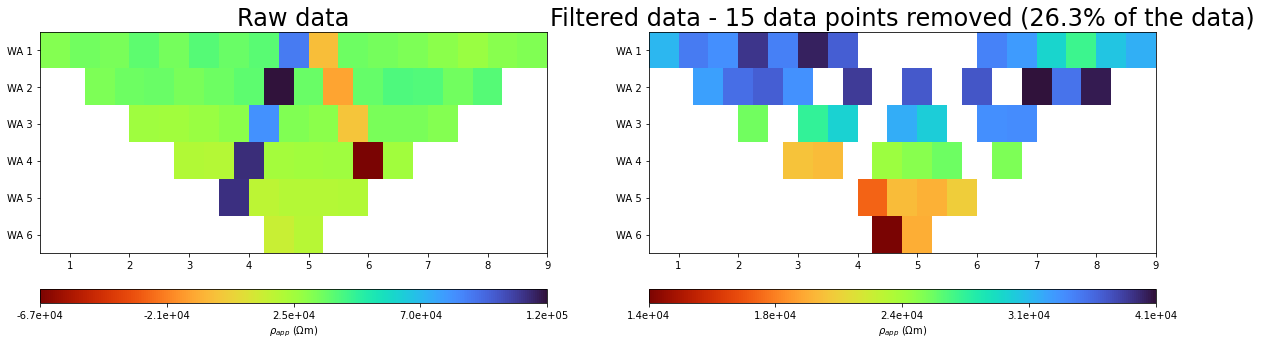

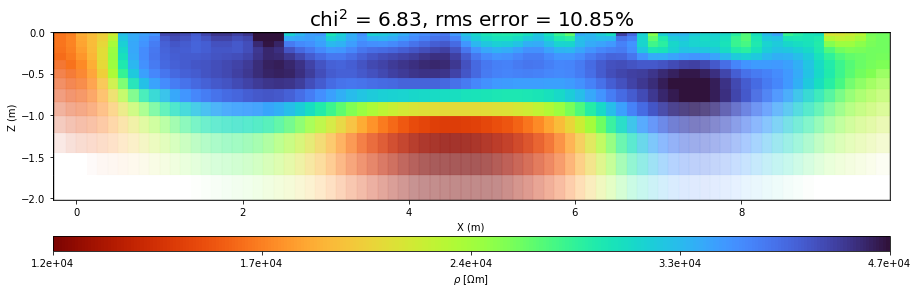

In [7]:
# load data (separated into electrodes and data file for convenience)

elecs = pd.read_csv('data_AERT/craterlake_electrodes.txt', sep='\t')
data_in = pd.read_csv('data_AERT/craterlake_data.txt',sep='\t')
n_data = 57
n_header = 3

# elecs = pd.read_csv('data_AERT/craterlake_electrodes2010.txt', sep='\t')
# data_in = pd.read_csv('data_AERT/craterlake_data2010.txt',sep=' ')
# n_data = 56
# n_header = 2

n_lines = n_data + n_header
n_surveys = int(len(data_in)/(n_lines))

# choose some random datasets...

# import random

# n_tests = 5

# test_i = []
# for i in range(n_tests):
#     test_i.append(random.randint(0, n_surveys))
    
# test_i = np.sort(test_i)


# ... or test a couple specific datasets

test_i = [339] 

# 424 has a few data points removed
# 339 has a few data points removed 
# 543 is where it crashed last time, due to too many data points removed
# 783 lots of bad data points (dataset filtered)

# make dictionary to store results

ert_all = dict.fromkeys(['rho_s','sens','survey_name','rms'])
data_all = dict.fromkeys(['a','b','m','n','err','u','i','k','rhoa','used','survey_name',]) # TODO: could be more general?


for j in range(0,len(test_i)):

    data = pg.DataContainerERT()

    for k in range(0,len(E)):
        data.createSensor([E[k], 0.0]) # 2D, no topography

    cf = []
    for k in range(0,n_data):
        cf.append([A[k]-1,B[k]-1,M[k]-1,N[k]-1])

    for k in range(0,n_data):
        data.createFourPointData(k, *map(int, cf[k])) 

    i = test_i[j]    
    
    filename = data_in.iloc[i*n_lines]['U0(mV)'][0:10] + ' ' + data_in.iloc[i*n_lines]['U90(mV)'][0:8] # use date and time to ID surveys
    
    print(filename)
    
    data['err'] = np.array(data_in['errorU0(%)'].iloc[(i*n_lines)+n_header:(i+1)*n_lines].astype(float))
    data['u'] = np.array(data_in['U0(mV)'].iloc[(i*n_lines)+n_header:(i+1)*n_lines].astype(float)/1000)
    data['i'] = np.array(data_in['I(mA)'].iloc[(i*n_lines)+n_header:(i+1)*n_lines].astype(float)/1000)
    
    grid = pg.createGrid(
        x=xlocs,
        y=ylocs,
        marker=1, 
        worldBoundaryMarker=True
    )  
    
    
    # test standard inversion
    ##############################
    
    mgr, ert_inv,data_filt = process_ERT_data(
        data_raw = data,
        survey_name = filename,
        mesh=grid, # for unstructured mesh, can just say mesh=None
        start_model=None, # set to None for no temporal constraint
        plotdata=True,
        plotmodel=True,
        plotmisfit=False)  


#     # test time-lapse inversion 
#     ##############################

#     if ert_all['rho_s']==None: # for first iteration, run a regular inversion
#         print('First inversion')
#         mgr, ert_inv,data_filt = process_ERT_data(
#             data_raw = data,
#             survey_name = filename,
#             mesh=grid, # for unstructured mesh, can just say mesh=None
#             start_model=None, # set to None for no temporal constraint
#             plotdata=True,
#             plotmodel=True,
#             plotmisfit=False
#         )  
        
#     else: # for subsequent inversions, use time-lapse
                
#         # check if the previous time step was inverted.
#         # if it wasn't, e.g. data were poor quality, look further back (up to 6 time steps - an arbitrary threshold) for a starting model

#         if max(ert_all['rho_s'])==-999: # check to see if any previous inverted result is suitable
#             m0=None
#             print('No suitable starting model')
                
#         else: # look progresssively backwards in time to find a suitable starting model. Stop at 6 
#             if len(np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-1])[0])==1: 
                
#                 k=1

#                 while len(np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-k])[0])==1 and k < 6 and j-k > 0:
#                     k = k+1

#                 if len(np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-k])[0])==1: # not able to find a suitable starting model
#                     m0 = None
#                     print('No suitable starting model found')
                    
#                 else: # set starting model
#                     m0=np.array(ert_all['rho_s'])[np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-k])]
#                     print('Using starting model from %.0f time steps ago'%k)

#             else: 
#                 m0=np.array(ert_all['rho_s'])[np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-1])]
#                 print('Using starting model from previous time step')

#         mgr, ert_inv,data_filt = process_ERT_data(
#             data_raw = data,
#             survey_name = filename,
#             mesh=grid, # for unstructured mesh, can just say mesh=None
#             start_model = m0, # set to None for no temporal constraint
#             plotdata=True,
#             plotmodel=True,
#             plotmisfit=False
#         )          
        
#     ##############################
    
    
    # append inverted results
    if ert_inv == None:
        pass
    else:
        
        if ert_all['rho_s']==None:
            ert_all = ert_inv 
        else:
            ert_all = {key: ert_all[key] + ert_inv[key] for key in ert_all}
    
    # append data
    if data_filt == None:
        pass
    else:
        if data_all['a']==None:
            data_all = data_filt
        else:
            data_all = {key: data_all[key] + data_filt[key] for key in data_all}

# convert dictionaries to dataframes
if ert_all['rho_s']==None:
    pass
else:
    ert_all = pd.DataFrame.from_dict(ert_all)
    
if data_all['a']==None:
    pass
else:
    data_all = pd.DataFrame.from_dict(data_all)

## Run time-lapse inversion

## 2010

In [8]:

# # load data (separated into electrodes and data file for convenience)

# elecs = pd.read_csv('data_AERT/craterlake_electrodes2010.txt', sep='\t')
# data_in = pd.read_csv('data_AERT/craterlake_data2010.txt',sep=' ')
# n_data = 56
# n_header = 2

# n_lines = n_data + n_header
# n_surveys = int(len(data_in)/(n_lines))


# # make dictionary to store results

# ert_all = dict.fromkeys(['rho_s','sens','survey_name','rms'])
# data_all = dict.fromkeys(['a','b','m','n','err','u','i','k','rhoa','valid','used','survey_name',]) #could be more general?

# for i in range(0,n_surveys):
#     print('Inverting survey %.0f/%.0f'%(i,n_surveys))
# # for i in range(0,20): # this is just testing the first few datasets

#     data = pg.DataContainerERT()

#     for k in range(0,len(E)):
#         data.createSensor([E[k], 0.0]) # 2D, no topography

#     cf = []
#     for k in range(0,n_data):
#         cf.append([A[k]-1,B[k]-1,M[k]-1,N[k]-1])

#     for k in range(0,n_data):
#         data.createFourPointData(k, *map(int, cf[k])) 
    
#     filename = data_in.iloc[i*n_lines]['U0(mV)'][0:10] + ' ' + data_in.iloc[i*n_lines]['U90(mV)'][0:8] # use date and time to ID surveys
    
#     data['err'] = np.array(data_in['errorU0(%)'].iloc[(i*n_lines)+n_header:(i+1)*n_lines].astype(float))
#     data['u'] = np.array(data_in['U0(mV)'].iloc[(i*n_lines)+n_header:(i+1)*n_lines].astype(float)/1000)
#     data['i'] = np.array(data_in['I(mA)'].iloc[(i*n_lines)+n_header:(i+1)*n_lines].astype(float)/1000)
    
#     grid = pg.createGrid(
#         x=xlocs,
#         y=ylocs,
#         marker=1, 
#         worldBoundaryMarker=True
#     )

        
#     if ert_all['rho_s']==None: # for first iteration, run a regular inversion
        
#         print('First inversion')
        
#         mgr, ert_inv,data_filt = process_ERT_data(
#             data_raw = data,
#             survey_name = filename,
#             mesh=grid, # for unstructured mesh, can just say mesh=None
#             start_model=None, # set to None for no temporal constraint
#             plotdata=False,
#             plotmodel=False,
#             plotmisfit=False
#         )  
        
#     else: # for subsequent inversions, use time-lapse
                
#         # check if the previous time step was inverted.
#         # if it wasn't, e.g. data were poor quality, look further back (up to 6 time steps - an arbitrary threshold) for a starting model

#         if max(ert_all['rho_s'])==-999: # check to see if any previous inverted result is suitable
#             m0=None
#             print('No suitable starting model')
                
#         else: # look progresssively backwards in time to find a suitable starting model. Stop at 6 
#             if len(np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-1])[0])==1: 
                
#                 k=1

#                 while len(np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-k])[0])==1 and k < 6 and j-k > 0:
#                     k = k+1

#                 if len(np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-k])[0])==1: # not able to find a suitable starting model
#                     m0 = None
#                     print('No suitable starting model found')
                    
#                 else: # set starting model
#                     m0=np.array(ert_all['rho_s'])[np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-k])]
#                     print('Using starting model from %.0f time steps ago'%k)

#             else: 
#                 m0=np.array(ert_all['rho_s'])[np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-1])]
#                 print('Using starting model from previous time step')
        
#         mgr, ert_inv,data_filt = process_ERT_data(
#             data_raw = data,
#             survey_name = filename,
#             mesh=grid, # for unstructured mesh, can just say mesh=None
#             start_model = m0, # set to None for no temporal constraint
#             plotdata=False,
#             plotmodel=False,
#             plotmisfit=False
#         )          
        
#     # append inverted results
#     if ert_inv == None:
#         pass
#     else:
#         if ert_all['rho_s']==None:
#             ert_all = ert_inv 
#         else:
#             ert_all = {key: ert_all[key] + ert_inv[key] for key in ert_all}
    
#     # append data
#     if data_filt == None:
#         pass
#     else:
#         if data_all['a']==None:
#             data_all = data_filt
#         else:
#             data_all = {key: data_all[key] + data_filt[key] for key in data_all}

# # convert dictionaries to dataframes
# if ert_all['rho_s']==None:
#     pass
# else:
#     ert_all = pd.DataFrame.from_dict(ert_all)
    
# if data_all['a']==None:
#     pass
# else:
#     data_all = pd.DataFrame.from_dict(data_all)
    
# ert_all.to_csv('data_AERT/inverted_data/ert_all_2010')
# data_all.to_csv('data_AERT/inverted_data/data_all_2010')
# grid.exportVTK('data_AERT/inverted_data/mesh_2010')


## 2019

In [9]:

# # load data (separated into electrodes and data file for convenience)

# elecs = pd.read_csv('data_AERT/craterlake_electrodes.txt', sep='\t')
# data_in = pd.read_csv('data_AERT/craterlake_data.txt',sep='\t')


# n_data = 57
# n_header = 3
# n_lines = n_data + n_header
# n_surveys = int(len(data_in)/(n_lines))


# n_lines = n_data + n_header
# n_surveys = int(len(data_in)/(n_lines))


# # make dictionary to store results

# ert_all = dict.fromkeys(['rho_s','sens','survey_name','rms'])
# data_all = dict.fromkeys(['a','b','m','n','err','u','i','k','rhoa','valid','used','survey_name',]) #could be more general?

# for i in range(0,n_surveys):
#     print('Inverting survey %.0f/%.0f'%(i,n_surveys))
# # for i in range(0,20): # this is just testing the first few datasets

#     data = pg.DataContainerERT()

#     for k in range(0,len(E)):
#         data.createSensor([E[k], 0.0]) # 2D, no topography

#     cf = []
#     for k in range(0,n_data):
#         cf.append([A[k]-1,B[k]-1,M[k]-1,N[k]-1])

#     for k in range(0,n_data):
#         data.createFourPointData(k, *map(int, cf[k])) 
    
#     filename = data_in.iloc[i*n_lines]['U0(mV)'][0:10] + ' ' + data_in.iloc[i*n_lines]['U90(mV)'][0:8] # use date and time to ID surveys
    
#     data['err'] = np.array(data_in['errorU0(%)'].iloc[(i*n_lines)+n_header:(i+1)*n_lines].astype(float))
#     data['u'] = np.array(data_in['U0(mV)'].iloc[(i*n_lines)+n_header:(i+1)*n_lines].astype(float)/1000)
#     data['i'] = np.array(data_in['I(mA)'].iloc[(i*n_lines)+n_header:(i+1)*n_lines].astype(float)/1000)
    
#     grid = pg.createGrid(
#         x=xlocs,
#         y=ylocs,
#         marker=1, 
#         worldBoundaryMarker=True
#     )

        
#     if ert_all['rho_s']==None: # for first iteration, run a regular inversion
        
#         print('First inversion')
        
#         mgr, ert_inv,data_filt = process_ERT_data(
#             data_raw = data,
#             survey_name = filename,
#             mesh=grid, # for unstructured mesh, can just say mesh=None
#             start_model=None, # set to None for no temporal constraint
#             plotdata=False,
#             plotmodel=False,
#             plotmisfit=False
#         )  
        
#     else: # for subsequent inversions, use time-lapse
                
#         # check if the previous time step was inverted.
#         # if it wasn't, e.g. data were poor quality, look further back (up to 6 time steps - an arbitrary threshold) for a starting model

#         if max(ert_all['rho_s'])==-999: # check to see if any previous inverted result is suitable
#             m0=None
#             print('No suitable starting model')
                
#         else: # look progresssively backwards in time to find a suitable starting model. Stop at 6 
#             if len(np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-1])[0])==1: 
                
#                 k=1

#                 while len(np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-k])[0])==1 and k < 6 and j-k > 0:
#                     k = k+1

#                 if len(np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-k])[0])==1: # not able to find a suitable starting model
#                     m0 = None
#                     print('No suitable starting model found')
                    
#                 else: # set starting model
#                     m0=np.array(ert_all['rho_s'])[np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-k])]
#                     print('Using starting model from %.0f time steps ago'%k)

#             else: 
#                 m0=np.array(ert_all['rho_s'])[np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-1])]
#                 print('Using starting model from previous time step')
        
#         mgr, ert_inv,data_filt = process_ERT_data(
#             data_raw = data,
#             survey_name = filename,
#             mesh=grid, # for unstructured mesh, can just say mesh=None
#             start_model = m0, # set to None for no temporal constraint
#             plotdata=False,
#             plotmodel=False,
#             plotmisfit=False
#         )          
        
#     # append inverted results
#     if ert_inv == None:
#         pass
#     else:
#         if ert_all['rho_s']==None:
#             ert_all = ert_inv 
#         else:
#             ert_all = {key: ert_all[key] + ert_inv[key] for key in ert_all}
    
#     # append data
#     if data_filt == None:
#         pass
#     else:
#         if data_all['a']==None:
#             data_all = data_filt
#         else:
#             data_all = {key: data_all[key] + data_filt[key] for key in data_all}

# # convert dictionaries to dataframes
# if ert_all['rho_s']==None:
#     pass
# else:
#     ert_all = pd.DataFrame.from_dict(ert_all)
    
# if data_all['a']==None:
#     pass
# else:
#     data_all = pd.DataFrame.from_dict(data_all)
    
# ert_all.to_csv('data_AERT/inverted_data/ert_all_2019')
# data_all.to_csv('data_AERT/inverted_data/data_all_2019')
# grid.exportVTK('data_AERT/inverted_data/mesh_2019')


## Save results locally
(Make sure to comment this after saving the first time so you don't accidentally overwrite a batch run!)

In [10]:
# ert_all.to_csv('data_AERT/inverted_data/ert_all_fulldataset')
# data_all.to_csv('data_AERT/inverted_data/data_all_fulldataset')
# grid.exportVTK('data_AERT/inverted_data/mesh_fulldataset')


## Load and plot both datasets (2010 and 2019)

In [11]:
grid = pg.load('data_AERT/inverted_data/mesh_2010.vtk')

ert_all_2010 = pd.read_csv('data_AERT/inverted_data/ert_all_2010', sep=',',index_col=0)
data_all_2010 = pd.read_csv('data_AERT/inverted_data/data_all_2010', sep=',',index_col=0)
n_surveys_proc_2010 = len(np.unique(ert_all_2010['survey_name']))

ert_all_2019 = pd.read_csv('data_AERT/inverted_data/ert_all_2019', sep=',',index_col=0)
data_all_2019 = pd.read_csv('data_AERT/inverted_data/data_all_2019', sep=',',index_col=0)
n_surveys_proc_2019 = len(np.unique(ert_all_2019['survey_name']))

ert_all = pd.concat([ert_all_2010,ert_all_2019])
data_all = pd.concat([data_all_2010,data_all_2019])
n_surveys_proc = n_surveys_proc_2010 + n_surveys_proc_2019

ert_all['survey_time'] = pd.to_datetime(ert_all['survey_name'], format='%d.%m.%Y %H:%M:%S')
data_all['survey_time'] = pd.to_datetime(data_all['survey_name'], format='%d.%m.%Y %H:%M:%S')

## Assess data quality

In [12]:
# average rms error
np.mean(ert_all['rms'][ert_all['rms']>-999])

8.652675896534435

In [13]:
# percentage of data points filtered
len(np.where(data_all['used']==0)[0])/len(data_all)*100

0.8181520671975565

In [14]:
# percentage of data sets filtered
len(np.where(ert_all['rho_s']==-999)[0])/len(np.unique(ert_all['survey_time']))*100

0.48692977960020506

In [15]:
# when were the worst quality datasets collected?
ert_all['survey_time'].iloc[np.where(ert_all['rho_s']==-999)[0]].values

array(['2010-04-26T20:00:00.000000000', '2010-05-04T16:00:00.000000000',
       '2010-05-04T20:00:00.000000000', '2010-05-05T00:00:00.000000000',
       '2010-05-05T20:00:00.000000000', '2010-05-06T08:00:00.000000000',
       '2010-07-02T20:00:00.000000000', '2010-07-03T00:00:00.000000000',
       '2010-07-03T08:00:00.000000000', '2010-07-05T12:00:00.000000000',
       '2010-07-05T16:00:00.000000000', '2010-07-05T20:00:00.000000000',
       '2010-07-06T00:00:00.000000000', '2010-07-06T04:00:00.000000000',
       '2010-07-06T16:00:00.000000000', '2010-11-04T08:00:00.000000000',
       '2019-06-22T12:00:00.000000000', '2019-08-21T12:00:00.000000000',
       '2019-08-22T00:00:00.000000000'], dtype='datetime64[ns]')

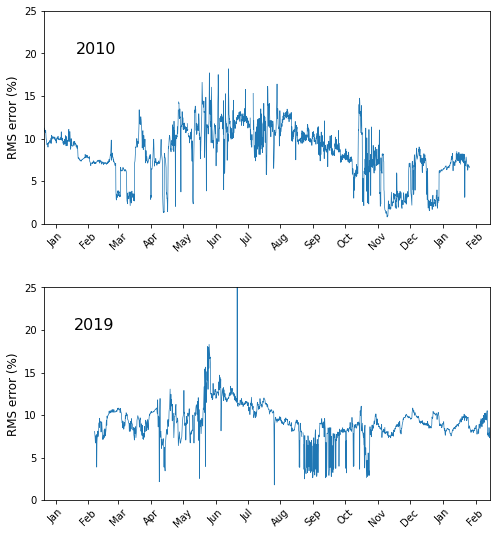

In [16]:
# plot rms errors

fs = 12 

dates = np.unique(data_all['survey_time'])
rms_vals = []
for i in range(len(dates)):
    rms_vals.append(ert_all['rms'][ert_all['survey_time']==dates[i]].values[0])

rms_vals= np.array(rms_vals)
rms_vals[rms_vals==-999]=np.nan

fmt_month = mdates.MonthLocator()

rms_vals= np.array(rms_vals)
rms_vals[rms_vals==-999]=np.nan

fig, ax = plt.subplots(2,1,figsize=[8,9],sharex=False)
ax[0].plot(dates[:n_surveys_proc_2010],rms_vals[:n_surveys_proc_2010],linewidth=0.7)
ax[1].plot(dates[n_surveys_proc_2010:],rms_vals[n_surveys_proc_2010:],linewidth=0.7)

for a in ax:
    a.set_ylabel('RMS error (%)',fontsize=fs);
    a.xaxis.set_major_locator(mdates.MonthLocator())
    a.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    a.tick_params(axis='x',labelrotation=45)
    a.set_ylim([0,25])

ytxt = 20

ax[0].text(dates[0]+np.timedelta64(30,'D'),ytxt,'2010',fontsize=fs+4)
ax[1].text(dates[0]+np.timedelta64(9*365+30,'D'),ytxt,'2019',fontsize=fs+4)

plt.subplots_adjust( hspace=0.3)

ax[0].set_xlim([datetime.date(2009, 12, 21), datetime.date(2011, 2, 15)])
ax[1].set_xlim([datetime.date(2018, 12, 21), datetime.date(2020, 2, 15)])

plt.savefig('rms_errors.png',format='png',dpi=dpi,bbox_inches='tight')

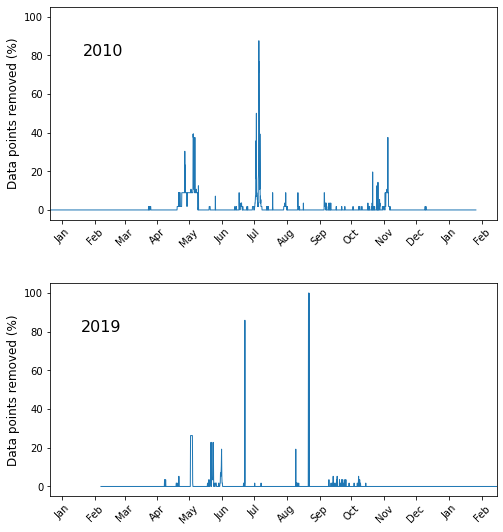

In [17]:
# plot number of filtered data points

dates = np.unique(data_all['survey_time'])
perc_filt = []
for i in range(len(dates)):
    used = data_all['used'][data_all['survey_time']==dates[i]]
    perc_filt.append(sum(used==0)/len(used)*100)

fmt_month = mdates.MonthLocator()

fig, ax = plt.subplots(2,1,figsize=[8,9],sharex=False)

ax[0].plot(dates[:n_surveys_proc_2010],perc_filt[:n_surveys_proc_2010],linewidth=1)
ax[1].plot(dates[n_surveys_proc_2010:],perc_filt[n_surveys_proc_2010:],linewidth=1)

for a in ax:
    a.set_ylabel('Data points removed (%)',fontsize=fs);
    a.xaxis.set_major_locator(mdates.MonthLocator())
    a.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    a.tick_params(axis='x',labelrotation=45)
    a.set_ylim([-5,105])

ytxt = 80

ax[0].text(dates[0]+np.timedelta64(30,'D'),ytxt,'2010',fontsize=fs+4)
ax[1].text(dates[0]+np.timedelta64(9*365+30,'D'),ytxt,'2019',fontsize=fs+4)

plt.subplots_adjust( hspace=0.3)

ax[0].set_xlim([datetime.date(2009, 12, 21), datetime.date(2011, 2, 15)])
ax[1].set_xlim([datetime.date(2018, 12, 21), datetime.date(2020, 2, 15)])


plt.savefig('perc_data_filt.png',format='png',dpi=dpi,bbox_inches='tight')

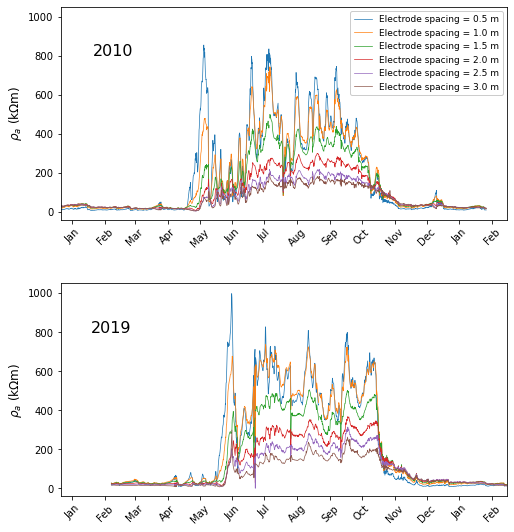

In [18]:
# calculate average apparent resistivity per depth level and plot as a function of time

nd = np.unique(data_all['survey_time'])
nk = np.unique(data_all['k'])
rhoa_avg = np.zeros([len(nd),len(nk)])
rhoa_avg_filt = np.zeros([len(nd),len(nk)])


for i in range(len(nd)):
    
    d_i = data_all[data_all['survey_time']==nd[i]]
    
    for j in range(len(nk)):
        
        d_ij = d_i[d_i['k']==nk[j]]
        rhoa_avg[i,j] = np.mean(d_ij['rhoa'])
        rhoa_avg_filt[i,j] = np.mean(d_ij['rhoa'][d_ij['used']==1])
        
fmt_month = mdates.MonthLocator()

fig, ax = plt.subplots(2,1,figsize=[8,9],sharex=False)
for i in range(len(nk)):
    ax[0].plot(dates[:n_surveys_proc_2010],rhoa_avg_filt.T[i][:n_surveys_proc_2010]/1000,linewidth=0.7,label='Electrode spacing = '+str(nk[i]/(2*np.pi))+' m')
    ax[1].plot(dates[n_surveys_proc_2010:],rhoa_avg_filt.T[i][n_surveys_proc_2010:]/1000,linewidth=0.7)
    
for a in ax:
    a.set_ylim([-40,1050]);
    a.set_ylabel(r'$\rho$$_{a}$ (k$\Omega$m)',fontsize=fs);
    a.xaxis.set_major_locator(mdates.MonthLocator())
    a.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    a.tick_params(axis='x',labelrotation=45)
#     a.ticklabel_format(axis='y', style='sci', scilimits=(4,4))

ytxt = 800

ax[0].text(dates[0]+np.timedelta64(30,'D'),ytxt,'2010',fontsize=fs+4)
ax[1].text(dates[0]+np.timedelta64(9*365+30,'D'),ytxt,'2019',fontsize=fs+4)

plt.subplots_adjust( hspace=0.3)

ax[0].set_xlim([datetime.date(2009, 12, 21), datetime.date(2011, 2, 15)])
ax[1].set_xlim([datetime.date(2018, 12, 21), datetime.date(2020, 2, 15)])

ax[0].legend(bbox_to_anchor=(1, 1), loc='upper right',framealpha=1,fontsize=fs-3)

plt.savefig('rhoa_avg.png',format='png',dpi=dpi,bbox_inches='tight')        

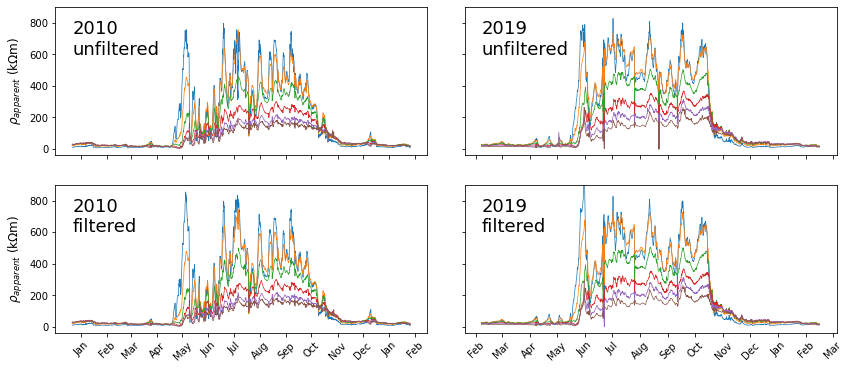

In [19]:

fig, ax = plt.subplots(2,2,figsize=[14,6])
for i in range(len(nk)):
    ax[0,0].plot(dates[:n_surveys_proc_2010],rhoa_avg.T[i][:n_surveys_proc_2010]/1000,linewidth=0.7)
    ax[0,1].plot(dates[n_surveys_proc_2010:],rhoa_avg.T[i][n_surveys_proc_2010:]/1000,linewidth=0.7)
    ax[1,0].plot(dates[:n_surveys_proc_2010],rhoa_avg_filt.T[i][:n_surveys_proc_2010]/1000,linewidth=0.7)
    ax[1,1].plot(dates[n_surveys_proc_2010:],rhoa_avg_filt.T[i][n_surveys_proc_2010:]/1000,linewidth=0.7)
    
for a in ax.ravel():
    a.set_ylim([-40,900]);
    a.set_ylabel(r'$\rho$$_{apparent}$ (k$\Omega$m)',fontsize=fs);
    a.xaxis.set_major_locator(mdates.MonthLocator())
    a.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    a.tick_params(axis='x',labelrotation=45)

ax[0,0].axes.get_xaxis().set_ticklabels([])
ax[0,1].axes.get_xaxis().set_ticklabels([])
ax[0,1].axes.get_yaxis().set_ticklabels([])
ax[1,1].axes.get_yaxis().set_ticklabels([])
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')

ytxt = 600
ax[0,0].text(dates[0],ytxt,'2010\nunfiltered',fontsize=18)
ax[1,0].text(dates[0],ytxt,'2010\nfiltered',fontsize=18)

ax[0,1].text(dates[n_surveys_proc_2010],ytxt,'2019\nunfiltered',fontsize=18)
ax[1,1].text(dates[n_surveys_proc_2010],ytxt,'2019\nfiltered',fontsize=18)

plt.subplots_adjust( wspace=0.1)

# plt.savefig('data_raw_filt.png',format='png',dpi=dpi,bbox_inches='tight')

## Plot representative resistivity models

In [20]:
# calculate coverage filter from sensitivity

def addCoverageAlpha(coverage, dropThreshold=0.4):

    C = np.asarray(coverage)
    C = C[~np.isnan(C)]
    #    print(np.min(C), np.max(C))

    if (np.min(C) < 0.) | (np.max(C) > 1.) | (np.max(C) < 0.5):

        nn, hh = np.histogram(C, 50)
        nnn = nn.cumsum(axis=0) / float(len(C))

        #        print("min-max nnn ", min(nnn), max(nnn))
        mi = hh[np.min(np.where(nnn > 0.02)[0])]

        if np.min(nnn) > dropThreshold:
            ma = np.max(C)
        else:
            ma = hh[np.max(np.where(nnn < dropThreshold)[0])]
#            mi = hh[min(np.where(nnn > 0.2)[0])]
#            ma = hh[max(np.where(nnn < 0.7)[0])]

        C = (C - mi) / (ma - mi)
        C[np.where(C < 0.)] = 0.0
        C[np.where(C > 0.95)] = 1.0
        
    return(C)

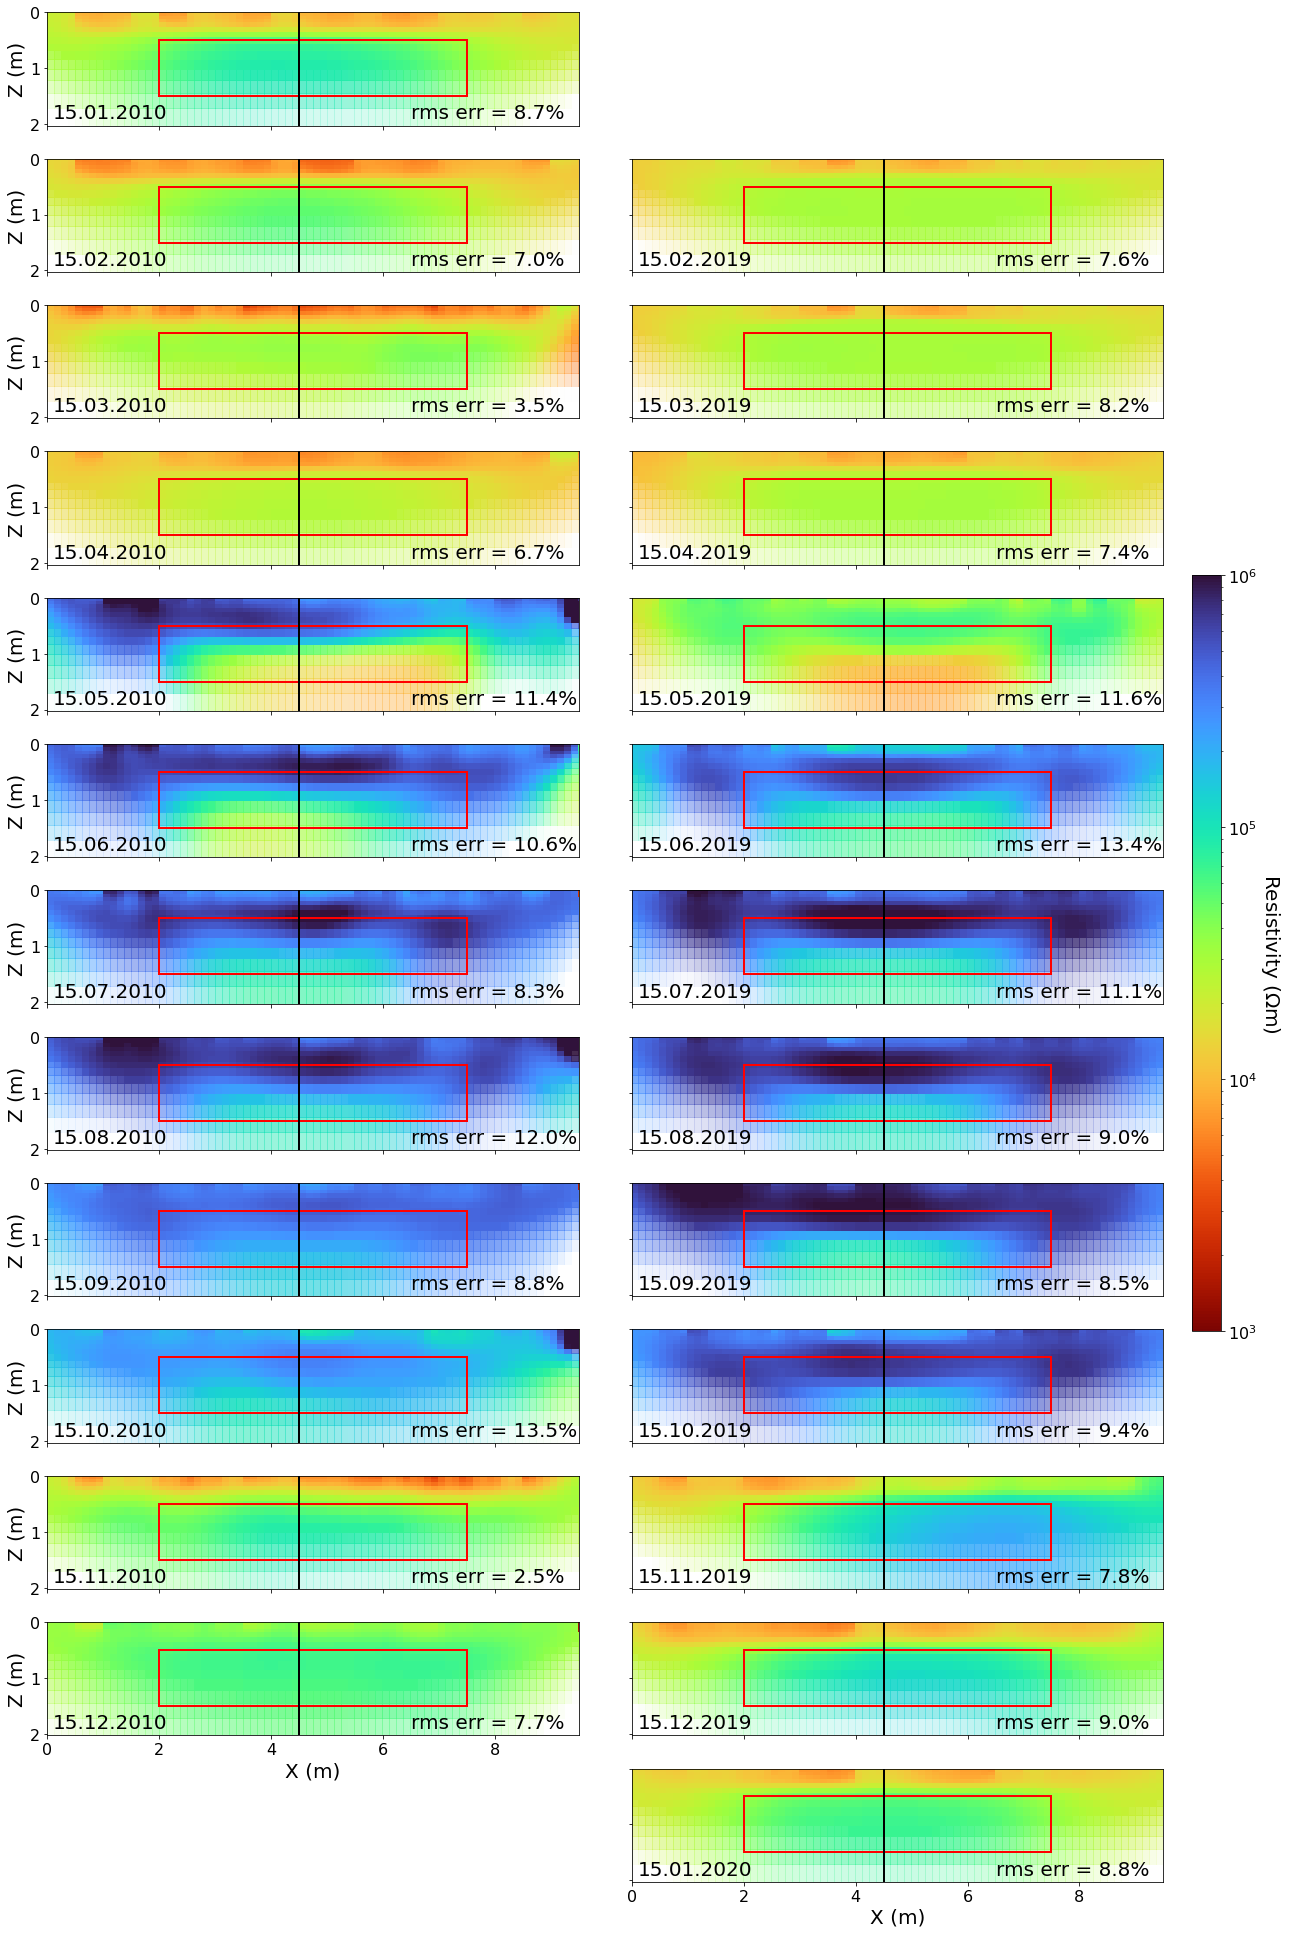

In [21]:
# plot 2D resistivity models - 1 per month

fig, ax = plt.subplots(13,2,figsize=[20,35])
ax = ax.flatten(order='F')

fs = 20
fs2 = 16

from matplotlib.patches import Rectangle

dates_r = ['15.01.2010 00:00:00','15.02.2010 00:00:00','15.03.2010 00:00:00','15.04.2010 00:00:00','15.05.2010 00:00:00','15.06.2010 00:00:00','15.07.2010 00:00:00','15.08.2010 00:00:00','15.09.2010 00:00:00','15.10.2010 00:00:00','15.11.2010 00:00:00','15.12.2010 00:00:00',]
X, Y = np.meshgrid(xlocs,ylocs)

cmin = 1000
cmax = 1000000

xborehole = 4.5

for i in range(len(dates_r)):

    rho = (ert_all['rho_s'].iloc[np.where(ert_all['survey_name'] ==dates_r[i])[0]]).values
    coverage = (ert_all['sens'].iloc[np.where(ert_all['survey_name'] ==dates_r[i])[0]]).values
    rms = (ert_all['rms'].iloc[np.where(ert_all['survey_name'] ==dates_r[i])[0]]).values[0]
    

    C1 = ax[i].pcolormesh(
        X,
        np.abs(Y),
        np.reshape(rho,[X.shape[0]-1,X.shape[1]-1]),
        cmap='turbo_r',
        shading='auto',
        norm=colors.LogNorm(vmin=cmin, vmax=cmax), # logarithmic scale
    )

    # add opacity filter
    fig.canvas.draw()

    cov = addCoverageAlpha(coverage)

    for k,j in zip(C1.get_facecolors(),cov.flatten(order='C')):
        k[3] = j 
    
    ax[i].text(0.1,1.9,dates_r[i][:10],fontsize=fs)
    ax[i].text(6.5,1.9,'rms err = %.1f%%'%rms,fontsize=fs)
    
    ax[i].axvline(x = xborehole, color = 'k',linewidth=2)
    ax[i].add_patch(Rectangle((2, 1.5), 5.5, -1. ,edgecolor='r',facecolor = 'none',lw=2))
        
    
 
C1 = ax[12].pcolormesh(
    X,
    np.abs(Y),
    np.reshape(rho,[X.shape[0]-1,X.shape[1]-1]),
    cmap='turbo_r',
    shading='auto',
    norm=colors.LogNorm(vmin=cmin, vmax=cmax), # logarithmic scale
) 

ax[12].set_visible(False)

cax = fig.add_axes([0.92, 0.35, 0.02, 0.3])
cbar = fig.colorbar(C1, cax=cax, )
cbar.ax.tick_params(labelsize=fs2) 
plt.ylabel(r'Resistivity ($\Omega$m)',fontsize=fs,rotation=270,labelpad=25);

    
    
dates_r = ['15.02.2019 0:00:00','15.03.2019 0:00:00','15.04.2019 0:00:00','15.05.2019 0:00:00','15.06.2019 0:00:00','15.07.2019 0:00:00','15.08.2019 0:00:00','15.09.2019 0:00:00','15.10.2019 0:00:00','15.11.2019 0:00:00','15.12.2019 0:00:00','15.01.2020 0:00:00',]
X, Y = np.meshgrid(xlocs,ylocs)

cmin = 1000
cmax = 1000000

for i in range(len(dates_r)):

    rho = (ert_all['rho_s'].iloc[np.where(ert_all['survey_name'] ==dates_r[i])[0]]).values
    coverage = (ert_all['sens'].iloc[np.where(ert_all['survey_name'] ==dates_r[i])[0]]).values
    rms = (ert_all['rms'].iloc[np.where(ert_all['survey_name'] ==dates_r[i])[0]]).values[0]
   

    C1 = ax[14+i].pcolormesh(
        X,
        np.abs(Y),
        np.reshape(rho,[X.shape[0]-1,X.shape[1]-1]),
        cmap='turbo_r',
        shading='auto',
        norm=colors.LogNorm(vmin=cmin, vmax=cmax), # logarithmic scale
    )

    # add opacity filter
    fig.canvas.draw()
    
    cov = addCoverageAlpha(coverage)

    for k,j in zip(C1.get_facecolors(),cov.flatten(order='C')):
        k[3] = j 
    
    ax[14+i].text(0.1,1.9,dates_r[i][:10],fontsize=fs)
    ax[14+i].text(6.5,1.9,'rms err = %.1f%%'%rms,fontsize=fs)
    
    ax[14+i].axvline(x = xborehole, color = 'k',linewidth=2)
    ax[14+i].add_patch(Rectangle((2, 1.5), 5.5, -1 ,edgecolor='r',facecolor = 'none',lw=2))
    

j=0  
for a in ax:
    a.tick_params(axis='both', which='major', labelsize=fs2)
    a.set_ylabel('Z (m)',fontsize=fs)
    a.set_xlabel('X (m)',fontsize=fs)
    a.set_aspect('equal', adjustable='box')
    a.set_xlim([min(E),max(E)])
    a.invert_yaxis()
    
    if j>11:
        a.yaxis.set_tick_params(labelleft=False)
        a.set_ylabel('')
    if j<11:
        a.xaxis.set_tick_params(labelbottom=False)
        a.set_xlabel('')   
    elif np.logical_and(j>12,j<25):
        a.xaxis.set_tick_params(labelbottom=False)
        a.set_xlabel('')       
        
    if j==12:
        a.axis('off')
    if j==13:
        a.axis('off')

    j=j+1

    
plt.subplots_adjust(wspace=0.1, hspace=0)

plt.savefig('2d_plots.png',format='png',dpi=dpi,bbox_inches='tight')

## zone of interest

In [22]:
# calculate average resistivity in zone of interest

xi = np.logical_and(xlocs>2,xlocs<7.5)
zi = np.logical_and(ylocs>-1.5,ylocs<-0.5)
I = np.logical_and(np.meshgrid(xi,zi)[0],np.meshgrid(xi,zi)[1])
I = I[:,1:]
I = I[1:]

dates_sort = np.sort(np.unique(ert_all['survey_time']))

rho_avg_zoi = []

for i in range(len(dates_sort)):

    if ert_all['rho_s'][ert_all['survey_time']==dates_sort[i]].values[0]==-999:
        rho_avg_zoi.append(np.nan)
    else:
        r = np.reshape(ert_all['rho_s'][ert_all['survey_time']==dates_sort[i]].values,[X.shape[0]-1,X.shape[1]-1])
        rho_avg_zoi.append(np.mean(r[I]))
    

In [23]:
# get resistivity for each month

year_month = np.unique(np.vstack([pd.to_datetime(dates).year,pd.to_datetime(dates).month]),axis=1)
Months = year_month[1]
Years = year_month[0]

rho_monthly = []
rho_avg_monthly = []

for i in range(len(Months)):
    rho_ph = np.array(rho_avg_zoi)[(np.where(np.logical_and(pd.to_datetime(dates).year==Years[i],pd.to_datetime(dates).month==Months[i]))[0])]
    rho_ph = rho_ph[~np.isnan(rho_ph)]
    rho_monthly.append(rho_ph)
    rho_avg_monthly.append(np.mean(rho_ph))


/var/folders/5z/g4c125y952l233l_4lb9yt6c0000gp/T/ipykernel_85083/1587915178.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bp = ax[1].boxplot(np.array(rho_monthly[1:14])/1000,widths = 0.2,positions=x1,patch_artist=True,
/var/folders/5z/g4c125y952l233l_4lb9yt6c0000gp/T/ipykernel_85083/1587915178.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bp = ax[1].boxplot(np.array(rho_monthly[14:])/1000,widths = 0.2,positions=x2,patch_artist=True,


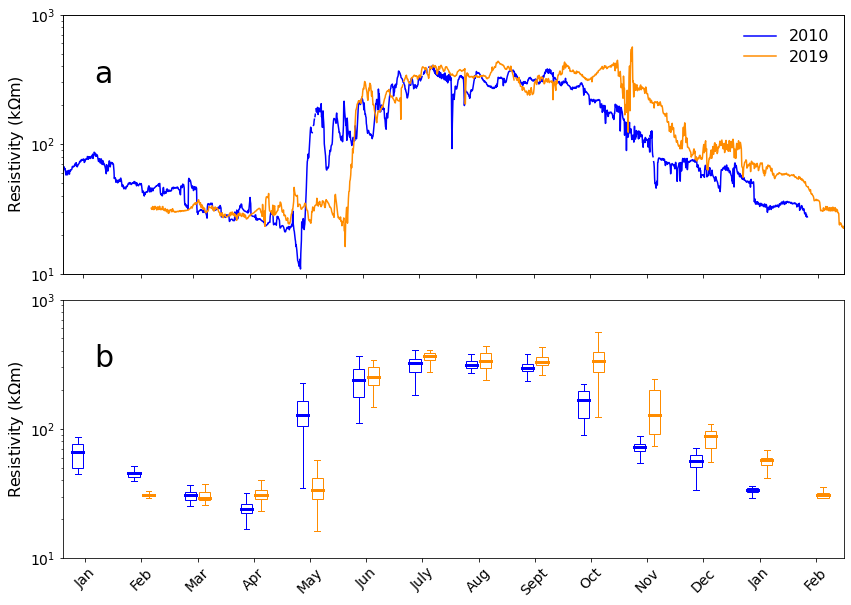

In [24]:
# plot zone of interest: all data + monthly values

fig, ax = plt.subplots(2,1,figsize=[14,10],sharex=False)

plt.subplots_adjust(hspace=0.1)

c1 = 'blue'
c2 = 'darkorange'

fmt_month = mdates.MonthLocator()


fs=16
fs2=14

twin = ax[0].twiny()

ax[0].plot(dates[:n_surveys_proc_2010],np.array(rho_avg_zoi[:n_surveys_proc_2010])/1000,c1,label='2010')
twin.plot(dates[n_surveys_proc_2010:],np.array(rho_avg_zoi[n_surveys_proc_2010:])/1000,c2,label='2019')

ax[0].set_ylabel(r'Resistivity (k$\Omega$m)',fontsize=fs);
ax[0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[0].tick_params(axis='x',labelrotation=45)

twin.xaxis.set_tick_params(top=False,labeltop=False)

ax[0].set_xlim([datetime.date(2009, 12, 21), datetime.date(2011, 2, 15)])
twin.set_xlim([datetime.date(2018, 12, 21), datetime.date(2020, 2, 15)])

ax[0].legend(loc='upper right', bbox_to_anchor=(1, 1),edgecolor='w',fontsize=fs);
twin.legend(loc='upper right', bbox_to_anchor=(1, 0.92),edgecolor='w',fontsize=fs);

ax[0].tick_params(axis='both', which='major', labelsize=fs2)
ax[0].set_yscale('log')
ax[0].set_ylim([10**1,10**3])
ax[0].set_xticklabels([])  
ax[0].text(ax[0].get_xlim()[0]+(ax[0].get_xlim()[1]-ax[0].get_xlim()[0])/25,300,'a',fontsize=30)


x1 = np.arange(0,13)-0.13 #starts in jan
x2 = np.arange(1,14)+0.13
x3 = np.arange(0,14)

bp = ax[1].boxplot(np.array(rho_monthly[1:14])/1000,widths = 0.2,positions=x1,patch_artist=True,             
            boxprops=dict(facecolor='w', color=c1),
            capprops=dict(color=c1),
            whiskerprops=dict(color=c1),
            flierprops=dict(color=c1, markeredgecolor=c1),
            medianprops=dict(color=c1,linewidth=3),
                   showfliers=False
            )


bp = ax[1].boxplot(np.array(rho_monthly[14:])/1000,widths = 0.2,positions=x2,patch_artist=True,   
            boxprops=dict(facecolor='w', color=c2),
            capprops=dict(color=c2),
            whiskerprops=dict(color=c2),
            flierprops=dict(color=c2, markeredgecolor=c2),
            medianprops=dict(color=c2,linewidth=3),
                   showfliers=False
            )


# todo: automate this
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','July', 'Aug','Sept', 'Oct','Nov','Dec','Jan','Feb']    
ax[1].set_xticks(x3)
ax[1].set_xticklabels(labels)
ax[1].tick_params(axis='x',labelrotation=45)
ax[1].set_yscale('log')
ax[1].set_ylim([10**1,10**3])
ax[1].set_ylabel(r'Resistivity (k$\Omega$m)',fontsize=fs);
ax[1].tick_params(axis='both', which='major', labelsize=fs2)
ax[1].set_xlim([-0.4,13.5]) #fudge factor
ax[1].text(ax[1].get_xlim()[0]+(ax[1].get_xlim()[1]-ax[1].get_xlim()[0])/25,300,'b',fontsize=30)

plt.savefig('pf_rho.png',format='png',dpi=dpi,bbox_inches='tight')     


## Extract information from  a virtual borehole

In [25]:
xborehole = 4.5

# find all cells within region

cells_borehole  = np.where(abs(np.array(grid.cellCenters()).T[0]-xborehole)==min(abs(np.array(grid.cellCenters()).T[0]-xborehole)))[0]
zbh = np.array(grid.cellCenters()).T[1][cells_borehole]

dt = []
rho_borehole = []
sens_borehole = []
z_borehole = np.flipud(np.unique(np.array(grid.cellCenters()).T[1]))
rms = []

dates_sort = np.sort(np.unique(ert_all['survey_time']))
    
if len(cells_borehole) > len(z_borehole):
    print('Chosen x-coordinate is at a cell boundary. Taking average of cells on either side.')

for i in range(n_surveys_proc):
    data_plt = ert_all[ert_all['survey_time']==dates_sort[i]]
    dt.append(data_plt['survey_time'].iloc[0])
    
    if len(cells_borehole) > len(z_borehole): # if borehole is at cell edge

        if data_plt['rho_s'].iloc[0]==-999: # if results were not inverted
            ph = np.empty(len(z_borehole))
            ph[:] = np.nan
            rho_borehole.append(ph)
            sens_borehole.append(ph)
            rms.append(np.nan)

        else: # if results were inverted, then take an average of cells on either side of borehole
            
            r_ph = np.array(data_plt['rho_s'].iloc[cells_borehole])
            s_ph = np.array(data_plt['sens'].iloc[cells_borehole])
            ph = []
            phs = []

            for i in range(len(z_borehole)):
                I = np.where(zbh == z_borehole[i])[0]
                ph.append(np.mean(r_ph[I]))
                phs.append(np.mean(s_ph[I]))

            rho_borehole.append(np.array(ph))
            sens_borehole.append(np.array(phs))
            rms.append(data_plt['rms'].iloc[0])     
            
    else: # if borehole is already near a cell centre
        
        if data_plt['rho_s'].iloc[0]==-999: # if results were note inverted
            
            ph[:] = np.nan
            rho_borehole.append(ph)
            sens_borehole.append(ph)
            rms.append(np.nan)
            
        else: # if results were inverted
            rho_borehole.append(np.array(data_plt['rho_s'].iloc[cells_borehole]))
            sens_borehole.append(np.array(data_plt['sens'].iloc[cells_borehole]))
            rms.append(data_plt['rms'].iloc[0])                    

      

Chosen x-coordinate is at a cell boundary. Taking average of cells on either side.


In [26]:
# save as a csv file for easy data sharing

DF = pd.DataFrame(np.round(np.array(rho_borehole).T,2),columns=dt)
DF.insert(0, "Z (m)", np.round(z_borehole,4))
DF.to_csv('virtual_borehole.csv')

## Line plot

Text(2019-01-18T12:00:00.000000000, 800000, '2019')

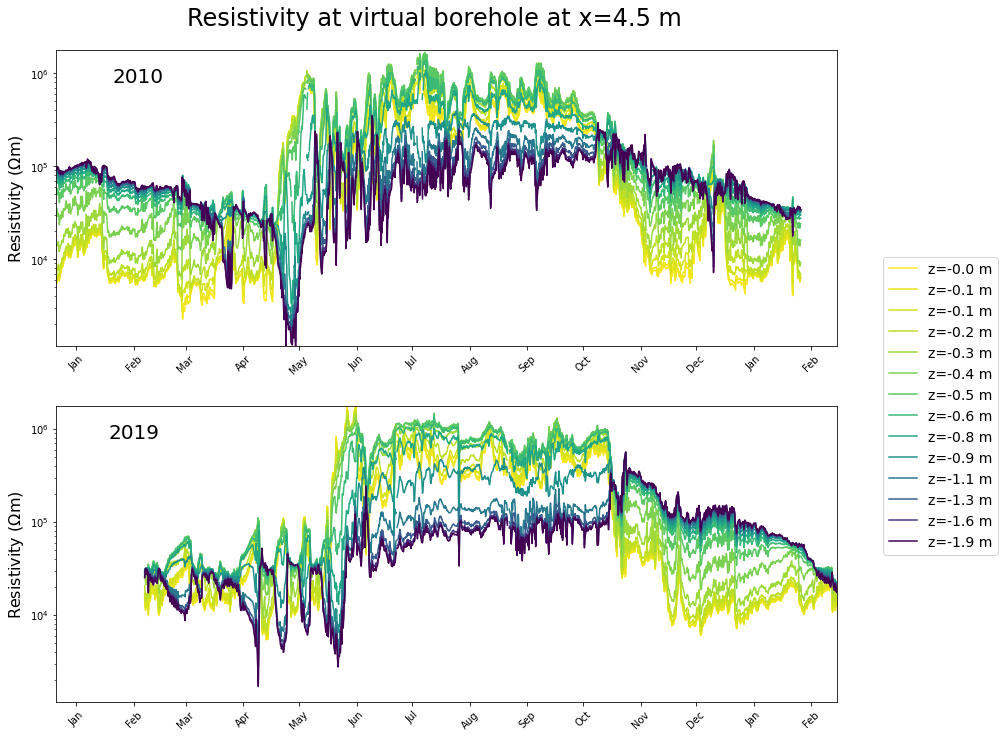

In [27]:

# plot the results

cmin = min(np.hstack(rho_borehole))
cmax = max(np.hstack(rho_borehole))

fs = 16

fig, ax = plt.subplots(2,1,figsize=[14,12])

norm = plt.Normalize(min(z_borehole), max(z_borehole))
cm = plt.cm.viridis
sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)

for i in range(len(z_borehole)):
    ax[0].plot_date(dt[:n_surveys_proc_2010], np.array(rho_borehole).T[i][:n_surveys_proc_2010],'-',color=cm(norm(z_borehole[i])),label='z=%.1f m'%z_borehole[i])

for i in range(len(z_borehole)):
    ax[1].plot_date(dt[n_surveys_proc_2010:], np.array(rho_borehole).T[i][n_surveys_proc_2010:],'-',color=cm(norm(z_borehole[i])),label='z=%.1f m'%z_borehole[i])

    
plt.suptitle('Resistivity at virtual borehole at x=%.1f m'%(xborehole),fontsize=24,y=0.93);
plt.legend(loc='center left', bbox_to_anchor=(1.05, 1),fontsize=fs-2);

x_bh = np.array(grid.cellCenters()).T[0][cells_borehole][0] # true borehole location

for a in ax:
    a.set_ylim([cmin,cmax]);
    a.set_yscale('log') # can comment this out to see plot with linear y-axis
    a.set_ylabel(r'Resistivity ($\Omega$m)',fontsize=fs);
    a.xaxis.set_major_locator(mdates.MonthLocator())
    a.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    a.tick_params(axis='x',labelrotation=45)
#     a.grid()

ax[0].set_xlim([datetime.date(2009, 12, 21), datetime.date(2011, 2, 15)])
ax[1].set_xlim([datetime.date(2018, 12, 21), datetime.date(2020, 2, 15)])

ytxt = 800000
ax[0].text(nd[0]+np.timedelta64(30,'D'),ytxt,'2010',fontsize=fs+4)
ax[1].text(nd[0]+np.timedelta64(9*365+30,'D'),ytxt,'2019',fontsize=fs+4)


## Calculate maximum gradients and estimate active layer depth

Note: we will find the sharpest gradient where resistivity is increasing with depth (i.e., thawed active layer above permafrost, or ice-poor layer above ice-rich layer).

Here, we can set some thresholds to better identify sharp boundaries (e.g. frozen/unfrozen interface):
1. the gradient should be in the near surface somewhere 
2. the gradient should be fairly steep
3. the average resistivity of the top layer could be below some threshold (i.e. if we are looking for depth of thaw layer)

These thresholds are arbitrary and may need to be tweaked.

In [28]:
z_gmax = []
z_thaw = []

Gmax_all = []
Gmax_thaw = []

for i in range(len(dt)):
    
    if np.isnan(rho_borehole[i][0]): # if dataset was not inverted, don't calculate gradient
        z_gmax.append(np.nan)
        z_thaw.append(np.nan)
        Gmax_all.append(np.nan)
        Gmax_thaw.append(np.nan)
        
    else:
        G = np.gradient(np.log(np.array(rho_borehole)[i]), z_borehole) # calculate gradient
        G_val = G[np.where(G==min(G))[0][0]]
        Gmax_all.append(G_val)
        Gmax_thaw.append(G_val)
        
        z_gmax.append(z_borehole[np.where(G==min(G))[0][0]]) # depth of max gradient (going from low to high resistivity)
        z_thaw.append(z_borehole[np.where(G==min(G))[0][0]]) # depth of max gradient (going from low to high resistivity)
        
        if z_gmax[i] <- 1: # if we have physically unrealistic values, discard
            z_gmax[i] = np.nan
            z_thaw[i] = np.nan
            Gmax_thaw[i] = np.nan
            
        if G_val > -4: # if gradients are small, discard
            z_thaw[i] = np.nan
            Gmax_thaw[i] = np.nan
            
        if np.mean(rho_borehole[i][:np.where(G==min(G))[0][0]])>30000: # if active layer is frozen
            z_thaw[i] = np.nan
            Gmax_thaw[i] = np.nan
            
    

/Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Virtual borehole plot

In [29]:
# scale coverage for plotting later (modified from pygimli)

C = np.hstack(sens_borehole)
C = C[~np.isnan(C)]
dropThreshold=0.4

if (np.min(C) < 0.) | (np.max(C) > 1.) | (np.max(C) < 0.5):

    nn, hh = np.histogram(C, 50)
    nnn = nn.cumsum(axis=0) / float(len(C))

    mi = hh[min(np.where(nnn > 0.02)[0])]

    if min(nnn) > dropThreshold:
        ma = max(C)
    else:
        ma = hh[max(np.where(nnn < dropThreshold)[0])]

    rho_alp = (sens_borehole - mi) / (ma - mi)
    rho_alp[np.where(rho_alp < 0.)] = 0.0
    rho_alp[np.where(rho_alp > 1.)] = 1.0

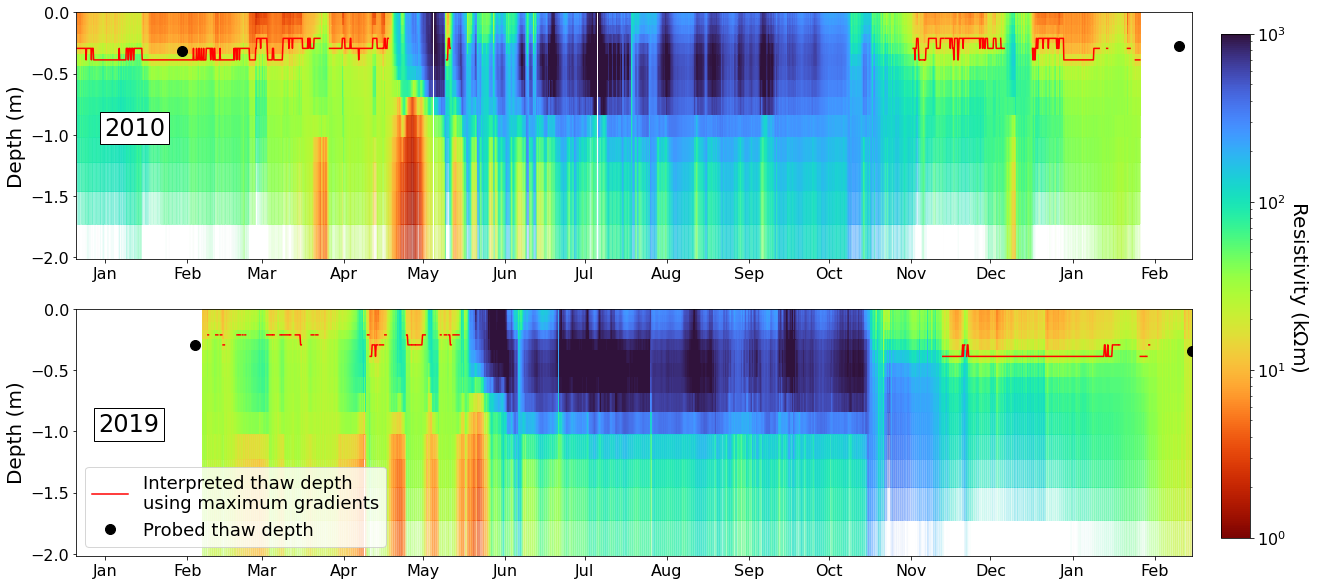

In [30]:
cmin = 1
cmax = 1e3

fs = 20
fs2 = 16 # tick labels

fig, ax = plt.subplots(2,1,figsize=[20,10])

X, Y = np.meshgrid(dt[:n_surveys_proc_2010],z_borehole)
C1 = ax[0].pcolormesh(
    X,
    Y,
    np.array(rho_borehole[:n_surveys_proc_2010]).T/1000,
    cmap='turbo_r',
    shading='auto',
    norm=colors.LogNorm(vmin=cmin, vmax=cmax), # logarithmic scale
)

X, Y = np.meshgrid(dt[n_surveys_proc_2010:],z_borehole)
C2 = ax[1].pcolormesh(
    X,
    Y,
    np.array(rho_borehole[n_surveys_proc_2010:]).T/1000,
    cmap='turbo_r',
    shading='auto',
    norm=colors.LogNorm(vmin=cmin, vmax=cmax), # logarithmic scale
)

ax[0].plot(dt[:n_surveys_proc_2010],z_thaw[:n_surveys_proc_2010],'r')
ax[1].plot(dt[n_surveys_proc_2010:],z_thaw[n_surveys_proc_2010:],'r',label='Interpreted thaw depth\nusing maximum gradients')

# note that probing data is not publically available. If you do not have access, comment the following lines to avoid an error.
probedata = pd.read_csv('data_AERT/probing_data.txt',delimiter='\t')

for i in range(len(probedata)):
    if i==0:

        ax[0].plot(datetime.datetime.strptime(probedata['date'].iloc[i], '%Y-%m-%d'),-probedata['mean'].iloc[i]/100,'ko',markersize=10)
        ax[1].plot(datetime.datetime.strptime(probedata['date'].iloc[i], '%Y-%m-%d'),-probedata['mean'].iloc[i]/100,'ko',markersize=10,label='Probed thaw depth')

    else:
        ax[0].plot(datetime.datetime.strptime(probedata['date'].iloc[i], '%Y-%m-%d'),-probedata['mean'].iloc[i]/100,'ko',markersize=10)
        ax[1].plot(datetime.datetime.strptime(probedata['date'].iloc[i], '%Y-%m-%d'),-probedata['mean'].iloc[i]/100,'ko',markersize=10)

plt.legend(fontsize=fs-2)

for a in ax:
    a.set_ylabel('Depth (m)',fontsize=fs)
    a.xaxis.set_major_locator(mdates.MonthLocator())
    a.xaxis.set_major_formatter(mdates.DateFormatter('%b'))    

ax[0].set_xlim([datetime.date(2009, 12, 21), datetime.date(2011, 2, 15)])
ax[1].set_xlim([datetime.date(2018, 12, 21), datetime.date(2020, 2, 15)])

cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(C1, cax=cax, )
cbar.ax.tick_params(labelsize=fs2) 
plt.ylabel(r'Resistivity (k$\Omega$m)',fontsize=fs,rotation=270,labelpad=25);

# add opacity filter
fig.canvas.draw()

for i,j in zip(C1.get_facecolors(),rho_alp[:n_surveys_proc_2010].flatten(order='F')):
    i[3] = j 
    
for i,j in zip(C2.get_facecolors(),rho_alp[n_surveys_proc_2010:].flatten(order='F')):
    i[3] = j 
    
for a in ax: 
    a.tick_params(axis='both', which='major', labelsize=fs2)
    

ytxt = -1
ax[0].text(nd[0]+np.timedelta64(10,'D'),ytxt,'2010',fontsize=fs+4,bbox=dict(facecolor='white', edgecolor='black'))
ax[1].text(nd[0]+np.timedelta64(9*365+10,'D'),ytxt,'2019',fontsize=fs+4,bbox=dict(facecolor='white', edgecolor='black'))


plt.savefig('aert_2010_2019.png',format='png',dpi=dpi,bbox_inches='tight')